# Downloading Subsets of ECCO Datasets

Andrew Delman, updated 2024-10-18.

Previous tutorials on the *ecco_access* package introduced [some use cases](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html) and demonstrated the various [access modes](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_modes.html). This tutorial goes into more detail on how to use the 'download_subset' mode.

But what if you don't want to download the entire global domain of ECCO? The [NASA Earthdata search](https://search.earthdata.nasa.gov/) interface and the [podaac_data_downloader](https://github.com/podaac/data-subscriber/blob/main/Downloader.md) utility both provide lat/lon subsetting, but this can't be used for the native llc90 grid of ECCO files. However, PO.DAAC does also make its datasets available through [OPeNDAP](https://podaac.jpl.nasa.gov/OPeNDAP-in-the-Cloud), and this enables spatial subsetting of the ECCO datasets. The access modes 'download_subset' used in the `ecco_access` libraries exploits OPeNDAP capabilities so that datasets can be subsetted prior to downloading, with a function call from your Python script or notebook. Here are some ways this can be used to subset ECCO files prior to download, along with possible use cases:

\- Regional subsetting (e.g., budget analyses that span many time granules but only a single tile or 2 adjacent tiles)

\- Depth subsetting (e.g., looking at SST or SSS, or the upper ocean only)

\- Data variable subsetting (e.g., downloading one SSH data variable instead of the four that are included in SSH datasets)

\- Time subsetting in non-continuous ranges (e.g., downloading boreal summer files from multiple years)


## Getting Started

Before using `ecco_access`, you need to [make it accessible to your Python path](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-ecco_access). You will also need to have your NASA Earthdata login credentials in your local `netrc` file--if you don't yet, follow the steps [here](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-Earthdata-login-credentials).

>**Note**: The parameters that are used for subsetting with mode = 'download_subset' are the same as those that are used with the function `ecco_podaac_download_subset`. The help documentation displayed below for `ecco_podaac_download_subset` provides a list of parameters that can also be passed to `ecco_podaac_access` and `ecco_podaac_to_xrdataset` when mode = 'download_subset' is used.

Let's look at the syntax of the `ecco_podaac_download_subset` function (which is invoked with mode = 'download_subset'):

In [1]:
import numpy as np
import xarray as xr
from os.path import join,expanduser

import ecco_access as ea

help(ea.ecco_podaac_download_subset)

Help on function ecco_podaac_download_subset in module ecco_download:

ecco_podaac_download_subset(ShortName, StartDate=None, EndDate=None, n_workers=4, force_redownload=False, vars_to_include='all', vars_to_omit=None, times_to_include='all', k_isel=[0, 50, 1], tile_isel=[0, 13, 1], j_isel=[0, 90, 1], i_isel=[0, 90, 1], Z_isel=[0, 50, 1], latitude_isel=[0, 360, 1], longitude_isel=[0, 720, 1], netcdf4=True, include_latlon_coords=True, download_or_list='download', list_filename='files_to_download.txt', download_root_dir=None, subset_file_id='')
    Downloads subsets of ECCOv4r4 datasets from PO.DAAC using OPeNDAP.
    This routine downloads ECCO datasets from PO.DAAC. It is adapted by Andrew Delman from the 
    ecco_podaac_download routine derived from the Jupyter notebooks created by Jack McNelis and Ian Fenty,
    with some code from the OPeNDAP subsetting download script by Toshio Mike Chin and Y. Jiang 
    (https://github.com/nasa/podaac_tools_and_services/blob/master/subset_openda

There are a lot of options in this mode! The ShortName of each ECCO dataset along with the associated variables and brief descriptions can be found [here](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#Dataset-ShortNames-and-variables-associated-with-them). If you are instead using one of the top-level *ecco_access* functions (`ecco_podaac_access` and `ecco_podaac_to_xrdataset`) then you can also enter a query that searches the [ECCO variable lists](#Dataset-ShortNames-and-variables-associated-with-them) to help you find the dataset that you want.

A few use cases are probably the best way to see what `ecco_podaac_download_subset` and mode = 'download_subset' can do, so let's try some.


## Example 1: Downloading monthly SSH in the North Atlantic

Say we want to look at SSH variability in the North Atlantic on the native grid. We could download granules of the full SSH dataset using `ecco_podaac_download`, e.g., for each of the months in the year 2000:

In [2]:
user_home_dir = expanduser('~')
# change download_root_dir as desired
download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

SSH_mon_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
files_dict = ea.ecco_podaac_access(SSH_mon_shortname,\
                                   StartDate='2000-01',EndDate='2000-12',\
                                   mode='download',\
                                   download_root_dir=download_root_dir)

created download directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4

Total number of matching granules: 12
DL Progress: 100%|#########################| 12/12 [00:10<00:00,  1.19it/s]

total downloaded: 71.01 Mb
avg download speed: 7.02 Mb/s
Time spent = 10.118713617324829 seconds


Now look at the contents of these SSH files by loading them as a dataset with `xarray`:

In [3]:
ds_SSH_mon_2000 = xr.open_mfdataset(files_dict[SSH_mon_shortname],\
                                    parallel=True,\
                                    compat='override',data_vars='minimal',coords='minimal')
ds_SSH_mon_2000

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 12, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2000-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2000-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a7c2a1c4-400c-11eb-9f79-0cc47a3f49c3

Note that there are four data variables in these files, but perhaps we only need one, the "dynamic sea surface height anomaly" (`SSH`). The function `ecco_podaac_download_subset` (and mode = 'download_subset') can be used to download only that data variable (along with the dimension and coordinate information).

Furthermore, we only need to look at one region, the North Atlantic. So most likely we don't need the entire 13-tile global domain of ECCO--but what tiles do we need? Let's use a simple function to find out. *Note: you need the ECCO native grid file downloaded for the script below; if you don't have it downloaded yet, use the code commented out at the top.*

In [4]:
# load grid file
grid_shortname = 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4'
ds_grid = xr.ecco_podaac_to_xrdataset(grid_shortname,\
                                      mode='download',\
                                      download_root_dir=download_root_dir).compute()

# find llc90 tiles in given bounding box
def llc90_tiles_find(ds_grid,latsouth,latnorth,longwest,longeast):
    lat_llc90 = ds_grid.YC.values
    lon_llc90 = ds_grid.XC.values
    
    cells_in_box = np.logical_and(np.logical_and(lat_llc90 >= latsouth,lat_llc90 <= latnorth),\
                                  ((lon_llc90 - longwest - 1.e-5) % 360) <= (longeast - longwest - 1.e-5) % 360)
    cells_in_box_tile_ind = cells_in_box.nonzero()[0]
    tiles_in_box = np.unique(cells_in_box_tile_ind)
    
    return tiles_in_box


# find tiles in North Atlantic
longwest = -80
longeast = 10
latsouth = 20
latnorth = 60

tiles_NAtl = llc90_tiles_find(ds_grid,latsouth,latnorth,longwest,longeast)
print('North Atlantic tiles: '+str(tiles_NAtl))

North Atlantic tiles: [ 2 10]


Seeing that the identified region is contained in tiles 2 and 10, we only need to download those two tiles. Let's repeat the SSH download above using mode = `download_subset` to select for the data variable `SSH` and the tiles 2 and 10. 

> Because of OPeNDAP syntax we need to express the selected tiles as a range \[2,13,8\], with a "start" of 2 and a "stride" of 8; the "end" can be any integer greater than 10, but no larger than 18.

In [5]:
# subsetting prior to download with mode = 'download_subset'
files_dict = ea.ecco_podaac_access(SSH_mon_shortname,\
                                            StartDate='2000-01',EndDate='2000-12',\
                                            mode='download_subset',\
                                            vars_to_include=['SSH'],\
                                            tile_isel=[2,13,8],\
                                            subset_file_id='SSHonly_NAtl')

Download to directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4

Please wait while program searches for the granules ...


Total number of matching granules: 12
DL Progress: 100%|#########################| 12/12 [00:40<00:00,  3.37s/it]

total downloaded: 3.21 Mb
avg download speed: 0.08 Mb/s
Time spent = 40.509522676467896 seconds


Note that the total download size of the subsetted files is much smaller (3 Mb instead of 71 Mb), but the download takes longer because of the subsetting that OPeNDAP does prior to the download. The *subset_file_id* is appended to the names of the downloaded files to distinguish them from non-subsetted files or other subsets (the default is to have no identifier).

Let's look at the contents of the subsetted files in a `xarray` dataset:

In [6]:
ds_SSH_mon_2000_sub = xr.open_mfdataset(files_dict[SSH_mon_shortname],\
                                        parallel=True,\
                                        compat='override',data_vars='minimal',coords='minimal')
ds_SSH_mon_2000_sub

<xarray.Dataset>
Dimensions:    (time: 12, tile: 2, j: 90, i: 90, j_g: 90, i_g: 90, nb: 4, nv: 2)
Coordinates: (12/15)
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(2, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 dask.array<chunksize=(2, 90, 90), meta=np.ndarray>
    XC         (tile, j, i) float32 dask.array<chunksize=(2, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(2, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(2, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(2, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * nb         (nb) float32 0.0 1.0 2.0 3.0
  * nv         (nv) float32 0.0 1.0
  * tile       (tile) int32 2 10
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
Data variables:
    SSH        (time, tile, j, i) float32 dask.array<chunksize=(1, 2, 90, 90), meta=np.ndarray>
Attributes: (12/58)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_end:            2000-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2000-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a7c2a1c4-400c-11eb-9f79-0cc47a3f49c3
    history_json:                 [{"$schema":"https:\/\/harmony.earthdata.na...

Looks similar to the previous non-subsetted dataset, but now there are only 2 tiles and one data variable. Let's map the mean SSH (relative to the geoid) for the year 2000 in the two tiles. For the quickest view, we can use the `plot_proj_to_latlon_grid` function that is part of the [ecco_v4_py](https://ecco-v4-python-tutorial.readthedocs.io/Installing_Python_and_Python_Packages.html#downloading-the-ecco-v4-py-python-package) package.

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


C:\cygwin64\home\adelman\Anaconda3\lib\site-packages\matplotlib\colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
C:\cygwin64\home\adelman\Anaconda3\lib\site-packages\matplotlib\colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


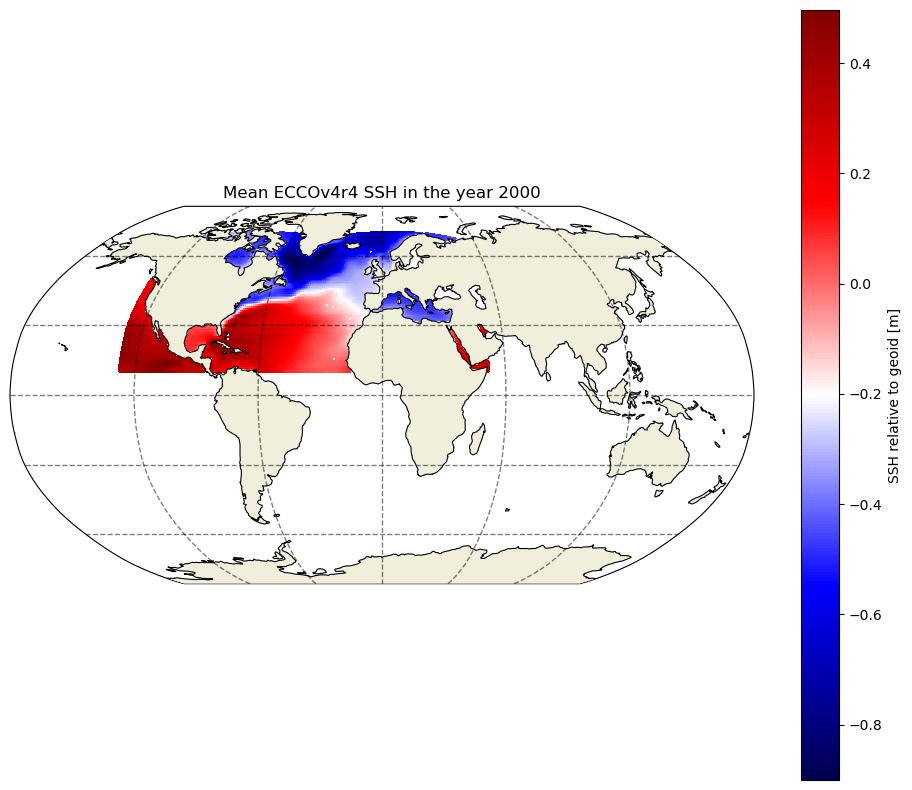

In [7]:
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

plt.figure(num=0,figsize=(12,10))
ecco.plot_proj_to_latlon_grid(ds_SSH_mon_2000_sub.XC.values,\
                              ds_SSH_mon_2000_sub.YC.values,\
                              np.mean(ds_SSH_mon_2000_sub.SSH.values,axis=0),\
                              cmap='seismic',\
                              show_colorbar=True,colorbar_label='SSH relative to geoid [m]')
plt.title('Mean ECCOv4r4 SSH in the year 2000')
plt.show()

But perhaps we don't want to plot the global domain when we only have data for part of the Northern Hemisphere. The `resample_to_latlon` function from the `ecco_v4_py` package allows us to reinterpolate the native grid output to a lat/lon grid of our choosing. Then we can use the versatile [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to produce the map. This is the package that also produces the maps in the `ecco.plot_proj_to_latlon_grid` function, but by importing `cartopy` directly we can customize the map more.

In [8]:
help(ecco.resample_to_latlon)

Help on function resample_to_latlon in module ecco_v4_py.resample_to_latlon:

resample_to_latlon(orig_lons, orig_lats, orig_field, new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, radius_of_influence=120000, fill_value=None, mapping_method='bin_average')
    Take a field from a source grid and interpolate to a target grid.
    
    Parameters
    ----------
    orig_lons, orig_lats, orig_field : xarray DataArray or numpy array  :
        the lons, lats, and field from the source grid
    
        new_grid_min_lat, new_grid_max_lat : float
                latitude limits of new lat-lon grid
    
    new_grid_delta_lat : float
        latitudinal extent of new lat-lon grid cells in degrees (-90..90)
    
    new_grid_min_lon, new_grid_max_lon : float
                longitude limits of new lat-lon grid (-180..180)
    
    new_grid_delta_lon : float
         longitudinal extent of new lat-lon grid cells in degrees
    
    ra

-129.95 49.95
-130.0 50.0
10.05 69.95
10.0 70.0


C:\cygwin64\home\adelman\Anaconda3\lib\site-packages\matplotlib\colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


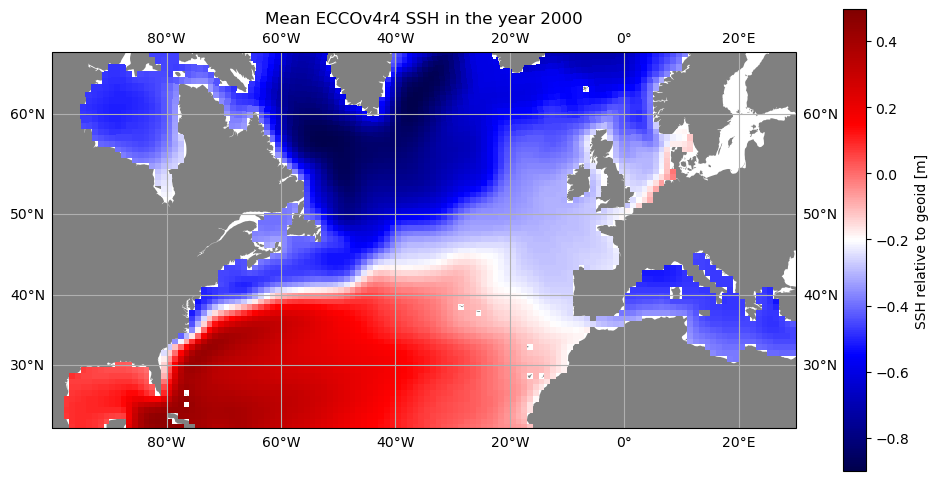

In [9]:
import cartopy
import cartopy.crs as ccrs

# resample 2000 mean SSH to lat/lon grid
lon_centers,lat_centers,\
  lon_edges,lat_edges,\
  SSH_mean_resampled = ecco.resample_to_latlon(ds_SSH_mon_2000_sub.XC.values,\
                                               ds_SSH_mon_2000_sub.YC.values,\
                                               np.mean(ds_SSH_mon_2000_sub.SSH.values,axis=0),\
                                               new_grid_min_lat=10,\
                                               new_grid_max_lat=70,\
                                               new_grid_delta_lat=0.1,\
                                               new_grid_min_lon=-130,\
                                               new_grid_max_lon=50,\
                                               new_grid_delta_lon=0.1,\
                                               mapping_method='nearest_neighbor')


# plot with orthographic projection: view from directly overhead 40 W, 40 N
fig,ax = plt.subplots(1,1,figsize=(12,10),\
                       subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=40)})
curr_plot = ax.pcolormesh(lon_centers,lat_centers,\
                          SSH_mean_resampled,\
                          transform=ccrs.PlateCarree(),cmap='seismic')
ax.set_extent([-100,30,20,65],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor='gray')   # add shaded land areas
ax.gridlines(draw_labels=True)
plt.colorbar(curr_plot,shrink=0.6,label='SSH relative to geoid [m]')
plt.title('Mean ECCOv4r4 SSH in the year 2000')
plt.show()

Alternatively, we can map the SSH without resampling (and maintain the integrity of the original grid) by concatenating the adjacent tiles along their shared edge to create a 180x90 map.

However...since tiles 7-12 are "rotated" tiles, we need to "unrotate" tile 10 before concatenating it with tile 2.

> For more information about tiles on the native grid, see [this tutorial](https://ecco-v4-python-tutorial.readthedocs.io/fields.html).

C:\Users\adelman\AppData\Local\Temp\ipykernel_11700\3523494463.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  curr_plot = plt.pcolormesh(unrotate_concat(ds_SSH_mon_2000_sub.XC.values),\


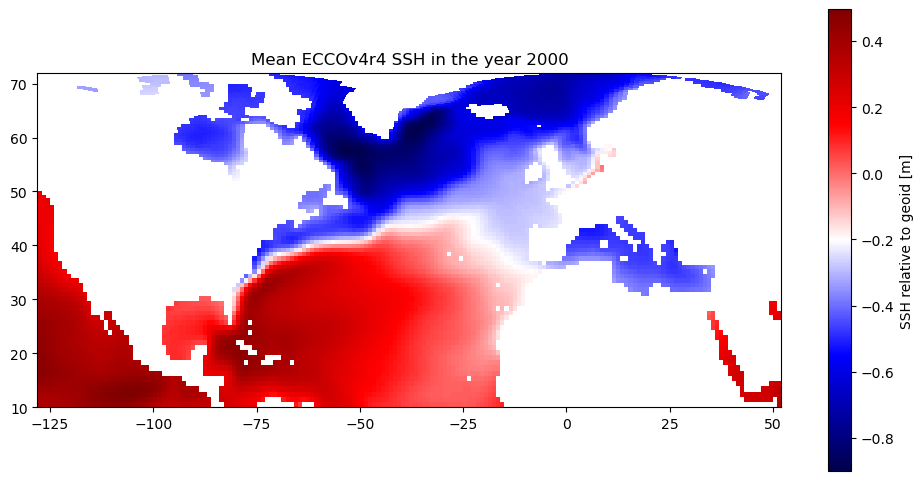

In [10]:
import matplotlib.pyplot as plt

def unrotate_concat(array_2tiles):
    unrotated_tile = np.rot90(array_2tiles[-1,:,:],k=1)
    concat_array = np.concatenate((unrotated_tile,array_2tiles[0,:,:]),axis=-1)
    
    return concat_array

plt.figure(figsize=(12,10))
curr_plot = plt.pcolormesh(unrotate_concat(ds_SSH_mon_2000_sub.XC.values),\
                           unrotate_concat(ds_SSH_mon_2000_sub.YC.values),\
                           unrotate_concat(np.mean(ds_SSH_mon_2000_sub.SSH.values,axis=0)),\
                           cmap='seismic')
plt.gca().set_aspect(1/np.cos((np.pi/180)*40))
plt.colorbar(curr_plot,shrink=0.6,label='SSH relative to geoid [m]')
plt.title('Mean ECCOv4r4 SSH in the year 2000')
plt.show()

Now let's use `cartopy` again to produce a map projection...and this time let's plot the difference of SSH anomaly in July vs. January 2000.

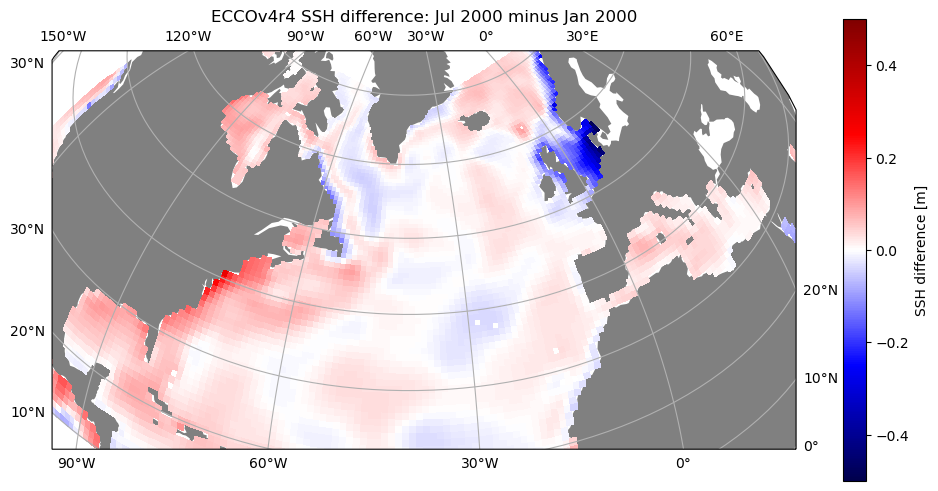

In [11]:
import cartopy
import cartopy.crs as ccrs

# plot with orthographic projection: view from directly overhead 40 W, 40 N
fig,ax = plt.subplots(1,1,figsize=(12,10),\
                       subplot_kw={'projection':ccrs.Orthographic(central_longitude=-40,central_latitude=40)})
curr_plot = ax.pcolormesh(unrotate_concat(ds_SSH_mon_2000_sub.XC.values),\
                          unrotate_concat(ds_SSH_mon_2000_sub.YC.values),\
                          unrotate_concat(np.diff(ds_SSH_mon_2000_sub.SSH.values[[0,6],:,:,:],axis=0).squeeze()),\
                          transform=ccrs.PlateCarree(),cmap='seismic',vmin=-.5,vmax=.5)
ax.set_extent([-100,30,20,65],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor='gray')   # add shaded land areas
ax.gridlines(draw_labels=True)
plt.colorbar(curr_plot,shrink=0.6,label='SSH difference [m]')
plt.title('ECCOv4r4 SSH difference: Jul 2000 minus Jan 2000')
plt.show()

We can see that there is a seasonal increase in SSH from winter to summer in most locations (likely driven by density changes/steric height), except there is a decrease in the marginal seas of northern Europe.


## Example 2: Hurricane season SST in the Gulf of Mexico

For another example, let's download sea surface temperature (SST) in the Gulf of Mexico, in order to look at the relationship between hurricanes and SST. There is no "SST" dataset available for ECCOv4r4; what we want is the `THETA` variable in the top layer (upper 10 m). We will use the subset download function to retrieve the top layer `THETA` at daily resolution in Aug-Oct 2004-2006 (2004 and 2005 were both very active hurricane seasons in the region).

We can find the ShortName of the dataset that contains `THETA` [here](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#Dataset-ShortNames-and-variables-associated-with-them). As with the previous example, we can also identify the indices we need to subset on the native grid (in this case the region is contained in a single tile, so we can also subset by `j` and `i`.

In [12]:
import numpy as np
import xarray as xr
from os.path import join,expanduser
import matplotlib.pyplot as plt

import ecco_access as ea


# find llc90 tiles and indices in given bounding box
def llc90_tiles_indices_find(ds_grid,latsouth,latnorth,longwest,longeast):
    lat_llc90 = ds_grid.YC.values
    lon_llc90 = ds_grid.XC.values
    
    cells_in_box = np.logical_and(np.logical_and(lat_llc90 >= latsouth,lat_llc90 <= latnorth),\
                                  ((lon_llc90 - longwest - 1.e-5) % 360) <= (longeast - longwest - 1.e-5) % 360)
    cells_in_box_tile_ind,cells_in_box_j_ind,cells_in_box_i_ind = cells_in_box.nonzero()    
    tiles_in_box = np.unique(cells_in_box_tile_ind)
    j_in_box = np.unique(cells_in_box_j_ind)
    i_in_box = np.unique(cells_in_box_i_ind)
    
    return tiles_in_box,j_in_box,i_in_box

# find tiles in North Atlantic
longwest = -100
longeast = -80
latsouth = 18
latnorth = 32

tiles_GoM,j_GoM,i_GoM = llc90_tiles_indices_find(ds_grid,latsouth,latnorth,longwest,longeast)
print('Gulf of Mexico tiles = '+str(tiles_GoM)+', j = '+str(j_GoM)+', i = '+str(i_GoM))

Gulf of Mexico tiles = [10], j = [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47], i = [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]


In [13]:
# use ecco_podaac_to_xrdataset to download requested data,
# and open it in the workspace as an xarray Dataset
ds_SST_GoM = ea.ecco_podaac_to_xrdataset('ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4',\
                                            vars_to_include=['THETA'],\
                                            times_to_include=['2004-08','2004-09','2004-10',\
                                                              '2005-08','2005-09','2005-10',\
                                                              '2006-08','2006-09','2006-10'],\
                                            k_isel=[0,1,1],\
                                            tile_isel=[10,11,1],\
                                            j_isel=[28,48,1],\
                                            i_isel=[66,82,1],\
                                            subset_file_id='SST_GoM')

Download to directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4

Please wait while program searches for the granules ...


Total number of matching granules: 276
DL Progress: 100%|#######################| 276/276 [21:12<00:00,  4.61s/it]

total downloaded: 42.08 Mb
avg download speed: 0.03 Mb/s
Time spent = 1272.8332271575928 seconds


In [14]:
ds_SST_GoM = ds_SST_GoM.compute()     # .compute() loads the dataset into workspace memory
ds_SST_GoM

<xarray.Dataset>
Dimensions:    (tile: 1, j_g: 20, i_g: 16, k_p1: 2, k_l: 1, j: 20, i: 16, nb: 4, k_u: 1, time: 276, k: 1, nv: 2)
Coordinates: (12/24)
    XG         (tile, j_g, i_g) float32 -100.0 -100.0 -100.0 ... -81.0 -81.0
    Zp1        (k_p1) float32 0.0 -10.0
    Zl         (k_l) float32 0.0
    YC         (tile, j, i) float32 31.83 30.98 30.11 ... 20.12 19.18 18.23
    XC         (tile, j, i) float32 -99.5 -99.5 -99.5 ... -80.5 -80.5 -80.5
    YG         (tile, j_g, i_g) float32 32.26 31.41 30.55 ... 20.6 19.65 18.7
    ...         ...
  * k_p1       (k_p1) int32 0 1
  * k_u        (k_u) int32 0
  * nb         (nb) float32 0.0 1.0 2.0 3.0
  * nv         (nv) float32 0.0 1.0
  * tile       (tile) int32 10
  * time       (time) datetime64[ns] 2004-08-01T12:00:00 ... 2006-10-31T12:00:00
Data variables:
    THETA      (time, k, tile, j, i) float32 nan nan nan ... 29.62 29.82 29.94
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_end:               2004-08-02T00:00:00
    time_coverage_resolution:        P1D
    time_coverage_start:             2004-08-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Da...
    uuid:                            c709dbee-4168-11eb-af01-0cc47a3f4aa1
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...

You can download data about the North Atlantic storms 2004-2006 [here](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ecco_access/misc/IBTrACS.NA.2004-2006.nc) (data sourced from [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) version 4). Two of the major hurricanes that traversed the Gulf of Mexico during this period were Ivan in 2004 and Katrina in 2005. Let's plot data on Ivan's wind speed in the Gulf of Mexico

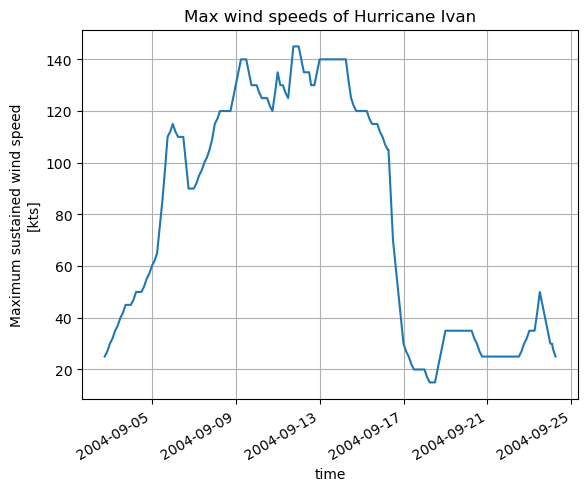

In [15]:
ds_hurr_0406 = xr.open_dataset('IBTrACS.NA.2004-2006.nc')
hurr_Ivan_ind = (ds_hurr_0406.name.values == b'IVAN').nonzero()[0][0]
ds_hurr_Ivan = ds_hurr_0406.isel(storm=hurr_Ivan_ind)

# plot time series of wind speed using xarray plot (wrapper of matplotlib.pyplot.plot)
ds_hurr_Ivan.usa_wind.plot(x='time')
plt.gca().grid(axis='both')
plt.gca().set_title('Max wind speeds of Hurricane Ivan')
plt.show()

Now let's look at the change in SST in the Gulf of Mexico from before (2004-09-05) to after (2004-09-17) Ivan's higher wind speeds.

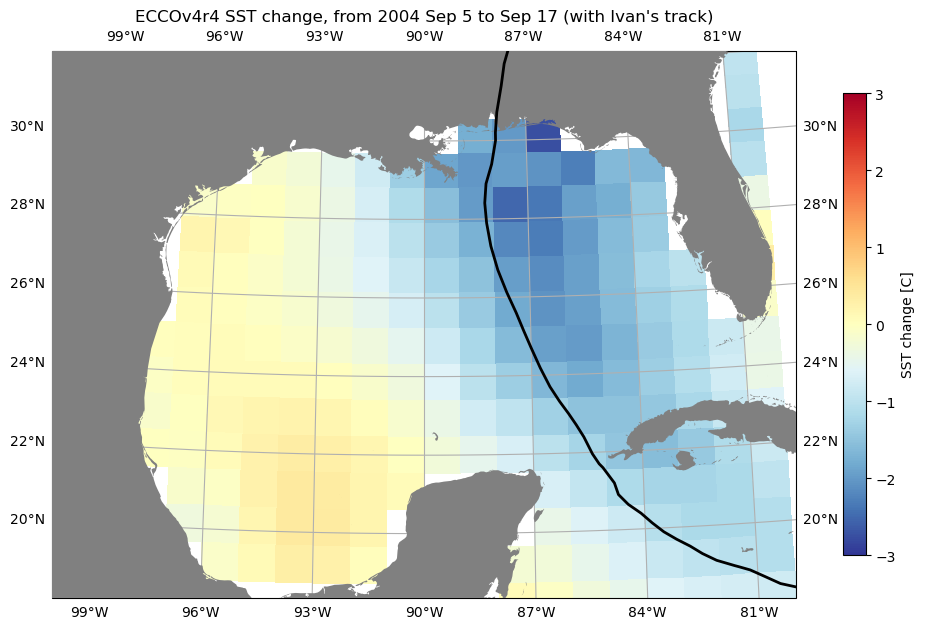

In [16]:
import cartopy
import cartopy.crs as ccrs

before_Ivan_SST_ind = np.argmin(np.abs(ds_SST_GoM.time.values - np.datetime64('2004-09-05T12')))
after_Ivan_SST_ind = np.argmin(np.abs(ds_SST_GoM.time.values - np.datetime64('2004-09-17T12')))

# plot with orthographic projection: view from directly overhead 90 W, 25 N
fig,ax = plt.subplots(1,1,figsize=(12,10),\
                       subplot_kw={'projection':ccrs.Orthographic(central_longitude=-90,central_latitude=25)})
curr_plot = ax.pcolormesh(ds_SST_GoM.XC.values.squeeze(),\
                          ds_SST_GoM.YC.values.squeeze(),\
                          np.diff(ds_SST_GoM.THETA.values[[before_Ivan_SST_ind,\
                                                           after_Ivan_SST_ind],:,:,:,:],axis=0).squeeze(),\
                          transform=ccrs.PlateCarree(),cmap='RdYlBu_r',vmin=-3,vmax=3)
ax.set_extent([-100,-80,18,32],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder=50)   # add shaded land areas
ax.plot(ds_hurr_Ivan.lon.values,\
        np.where(ds_hurr_Ivan.time.values < np.datetime64('2004-09-17T12'),ds_hurr_Ivan.lat.values,np.nan),\
        transform=ccrs.PlateCarree(),\
        linewidth=2,color='black',zorder=100)    # plot track of Ivan, before 2004 Sep 17
ax.gridlines(draw_labels=True)
plt.colorbar(curr_plot,shrink=0.6,label='SST change [C]')
plt.title('ECCOv4r4 SST change, from 2004 Sep 5 to Sep 17 (with Ivan\'s track)')
plt.show()

We can clearly see the "cold wake" effect of the hurricane's passage. Let's look at the same plot for Hurricane Katrina:

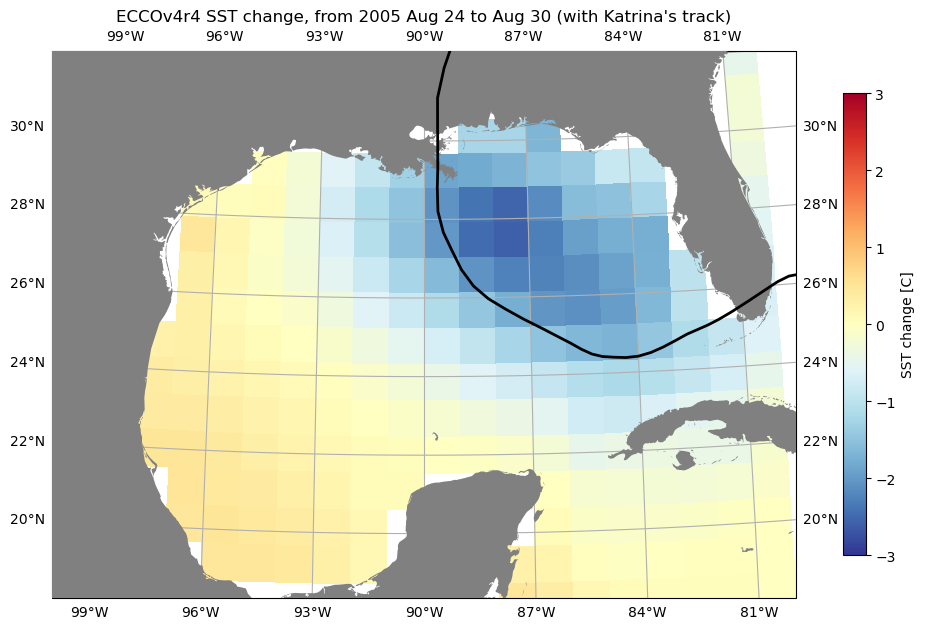

In [17]:
hurr_Katrina_ind = (ds_hurr_0406.name.values == b'KATRINA').nonzero()[0][0]
ds_hurr_Katrina = ds_hurr_0406.isel(storm=hurr_Katrina_ind)

before_Katrina_SST_ind = np.argmin(np.abs(ds_SST_GoM.time.values - np.datetime64('2005-08-24T12')))
after_Katrina_SST_ind = np.argmin(np.abs(ds_SST_GoM.time.values - np.datetime64('2005-08-30T12')))

# plot with orthographic projection: view from directly overhead 90 W, 25 N
fig,ax = plt.subplots(1,1,figsize=(12,10),\
                       subplot_kw={'projection':ccrs.Orthographic(central_longitude=-90,central_latitude=25)})
curr_plot = ax.pcolormesh(ds_SST_GoM.XC.values.squeeze(),\
                          ds_SST_GoM.YC.values.squeeze(),\
                          np.diff(ds_SST_GoM.THETA.values[[before_Katrina_SST_ind,\
                                                           after_Katrina_SST_ind],:,:,:,:],axis=0).squeeze(),\
                          transform=ccrs.PlateCarree(),cmap='RdYlBu_r',vmin=-3,vmax=3)
ax.set_extent([-100,-80,18,32],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder=50)   # add shaded land areas
ax.plot(ds_hurr_Katrina.lon.values,\
        ds_hurr_Katrina.lat.values,\
        transform=ccrs.PlateCarree(),\
        linewidth=2,color='black',zorder=100)    # plot track of Ivan, before 2004 Sep 17
ax.gridlines(draw_labels=True)
plt.colorbar(curr_plot,shrink=0.6,label='SST change [C]')
plt.title('ECCOv4r4 SST change, from 2005 Aug 24 to Aug 30 (with Katrina\'s track)')
plt.show()

Now let's look at this effect another way: at the time series of SST near 28.4 N, 87.5 W, where both hurricanes had an impact.

In [18]:
pt_lat = 28.4
pt_lon = -87.5

lon_dist = 111.1*np.cos((np.pi/180)*pt_lat)*(((ds_SST_GoM.XC.values.squeeze() - pt_lon + 180) % 360) - 180)
lat_dist = 111.1*(ds_SST_GoM.YC.values.squeeze() - pt_lat)
# np.argmin returns the index with the smallest values from the "flattened" array
cell_nearest_pt_flatind = np.argmin(((lon_dist**2) + (lat_dist**2))**(1/2))
# np.unravel_index finds the 2-D indices of the previous result
cell_j,cell_i = np.unravel_index(cell_nearest_pt_flatind,lon_dist.shape)

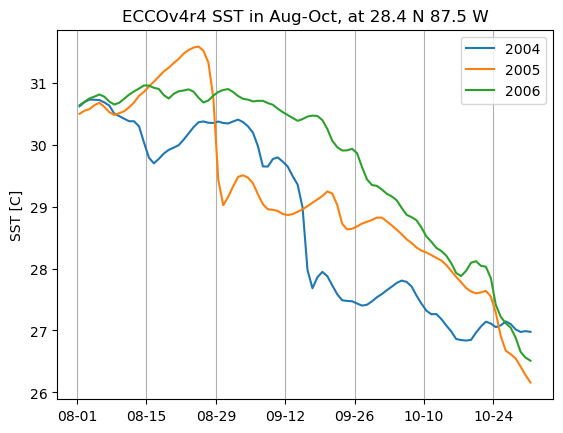

In [19]:
SST_atpt = ds_SST_GoM.THETA.isel(j=cell_j,i=cell_i).values.squeeze()

for year in range(2004,2007):
    curr_time_ind = (ds_SST_GoM.time.values.astype('datetime64[Y]') == np.datetime64(str(year),'Y')).nonzero()[0]
    plt.plot(ds_SST_GoM.time[curr_time_ind].values - np.datetime64(str(year)+'-08-01','ns')\
             + np.datetime64('2004-08-01','ns'),\
             SST_atpt[curr_time_ind],\
             label=str(year))
xticks = np.arange(np.datetime64('2004-08-01','ns'),np.datetime64('2004-11-01','ns'),np.timedelta64(14,'D'))
xticklabels = []
for xtick in xticks:
    xticklabels.append(str(xtick)[5:10])
plt.gca().set_xticks(xticks,labels=xticklabels)
plt.gca().grid(axis='x')
plt.ylabel('SST [C]')
plt.legend()
plt.title('ECCOv4r4 SST in Aug-Oct, at 28.4 N 87.5 W')
plt.show()

The quick decreases in SST (over 1 or 2 days) from the passage of both Ivan and Katrina are clearly visible, compared to 2006 when there were no major hurricanes passing over.


## Example 3: Generating URL list to download tropical Pacific salinity fluxes

Another option that `ecco_podaac_download_subset` provides is to generate a list of OPeNDAP URLs that would be used to download the files, without actually carrying out the downloads. This can be useful if you want to check that your request will download the files you want *before* downloading, or if you would prefer to carry out the downloads using `wget`, `curl`, or another utility.
> A bash shell script to download files from PO.DAAC using `wget` is provided [here](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ecco_access/Downloading_ECCO_datasets_from_PODAAC/wget_download_fromlist.sh).

Let's say we are interested in doing a freshwater or salinity budget in the tropical Pacific, in the upper 200 m. The tutorial on salt/salinity/freshwater budgets specifies [which datasets will be needed](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Salt_and_salinity_budget.html#Datasets-to-download) to close the budget. To limit the size of our downloads, we should first identify the tiles that we would need to download, and also in this case the depth range.

In [20]:
import numpy as np
import xarray as xr
from os.path import join,expanduser

import ecco_access as ea


# assumes grid file is in directory ~/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/
# change if your grid file location is different
grid_file_path = join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                                      'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4',\
                                      'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ds_grid = xr.open_dataset(grid_file_path)

# find llc90 tiles in given bounding box
def llc90_tiles_find(ds_grid,latsouth,latnorth,longwest,longeast):
    lat_llc90 = ds_grid.YC.values
    lon_llc90 = ds_grid.XC.values
    
    cells_in_box = np.logical_and(np.logical_and(lat_llc90 >= latsouth,lat_llc90 <= latnorth),\
                                  ((lon_llc90 - longwest - 1.e-5) % 360) <= (longeast - longwest - 1.e-5) % 360)
    cells_in_box_tile_ind = cells_in_box.nonzero()[0]
    tiles_in_box = np.unique(cells_in_box_tile_ind)
    
    return tiles_in_box


# find tiles in tropical Pacific
longwest = 145
longeast = 290
latsouth = -10
latnorth = 10

tiles_TPac = llc90_tiles_find(ds_grid,latsouth,latnorth,longwest,longeast)
print('Tropical Pacific tiles: '+str(tiles_TPac))


# find depth indices needed
depth_top = 0
depth_bottom = -200
depth_ind = np.logical_and(ds_grid.Zu.values < depth_top,ds_grid.Zl.values > depth_bottom).nonzero()[0]
print('Depth indices in range: '+str(depth_ind))

Tropical Pacific tiles: [ 8 11]
Depth indices in range: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Next we generate the list needed to download the monthly mean salinity fluxes (one of the datasets needed for the budget) with the option `download_or_list='list'`. The list will be written to the file `TPac_salbudget_download.txt` in the current directory.

In [21]:
ea.ecco_podaac_access('ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_MONTHLY_V4R4',\
                            StartDate='1992',EndDate='2017',\
                            k_isel=[0,17,1],\
                            tile_isel=[8,13,3],\
                            download_or_list='list',\
                            list_filename='TPac_salbudget_download.txt',\
                            subset_file_id='TPac',\
                            return_granules=False)

Download to directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_MONTHLY_V4R4

Please wait while program searches for the granules ...


Total number of matching granules: 312
URL list written/appended to TPac_salbudget_download.txt.
To download these files with wget,
the bash shell script wget_download_fromlist.sh may be invoked, e.g.:

bash ./wget_download_fromlist.sh -i TPac_salbudget_download.txt \ 
-P ~/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_MONTHLY_V4R4/ \ 
-n TPac -u username -p password


Note that if the file specified by `list_filename` already exists, the file is not overwritten; the download URLs are just appended to the end of the list. This is helpful for putting URLs from multiple requests in a single text file. Then the files can be downloaded in a single call to `wget`, e.g., using the shell script [wget_download_fromlist.sh](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ecco_access/Downloading_ECCO_datasets_from_PODAAC/wget_download_fromlist.sh).